In [ ]:
!git status

In [1]:
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/projects/speedup-gen-surgery

/content/gdrive/MyDrive/projects/speedup-gen-surgery


In [ ]:
!pip install -r requirements.txt

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from __future__ import print_function
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger  
import wandb
import sys
import os
import io
from PIL import Image
from model.predictor import PredictorDCGAN
from utils import load_pretrained_dcgan_gen, load_pretrained_dcgan_disc, load_target_image
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [ ]:
wandb.login()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
random_seed = 1
num_epochs = 1000
batch_size = 64
lr = 0.01
b1 = 0.9
b2 = 0.999
log_every = 50 # default value by Pytorch-Lightning
img_size = 64
train_percent = 0.8
gdl_weight = 0.01
realism_weight = 0.02

gen_path = './trained_model/dcgan.pth'
dataset_name= 'coco'
img_dir = './images/test2017'
mask_dir = './images/mask/testing_mask_dataset'
experiment_name = f'{dataset_name}.epoch={num_epochs}.lr={lr}.bs={batch_size}.b1={b1}.b2={b2}'
checkpoint_path = os.path.join('checkpoints', experiment_name)
tensorboard_path = os.path.join('tensorboard_logs', experiment_name)
# predictor_path = './predictor_checkpoints/predictor.epoch_1000.bs_64.lr_0.01.pt'

In [ ]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
# Taken from https://github.com/wileyw/VideoGAN/blob/master/loss_funs.py

def gdl_loss(gen_frames, gt_frames, alpha, mask):
    """
    Calculates the sum of GDL losses between the predicted and ground truth frames.
    @param gen_frames: The predicted frames at each scale.
    @param gt_frames: The ground truth frames at each scale
    @param alpha: The power to which each gradient term is raised.
    @return: The GDL loss.
    """
    filter_x_values = np.array(
        [
            [[[-1, 1, 0]], [[0, 0, 0]], [[0, 0, 0]]],
            [[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]],
            [[[0, 0, 0]], [[0, 0, 0]], [[-1, 1, 0]]],
        ],
        dtype=np.float32,
    )
    filter_x = nn.Conv2d(3, 3, (1, 3), padding=(0, 1))
    filter_x.weight = nn.Parameter(torch.from_numpy(filter_x_values))

    filter_y_values = np.array(
        [
            [[[-1], [1], [0]], [[0], [0], [0]], [[0], [0], [0]]],
            [[[0], [0], [0]], [[-1], [1], [0]], [[0], [0], [0]]],
            [[[0], [0], [0]], [[0], [0], [0]], [[-1], [1], [0]]],
        ],
        dtype=np.float32,
    )
    filter_y = nn.Conv2d(3, 3, (3, 1), padding=(1, 0))
    filter_y.weight = nn.Parameter(torch.from_numpy(filter_y_values))

    filter_x = filter_x
    filter_y = filter_y

    gen_dx = filter_x(gen_frames)
    gen_dy = filter_y(gen_frames)
    gt_dx = filter_x(gt_frames)
    gt_dy = filter_y(gt_frames)

    grad_diff_x = (1.0 - mask) * torch.pow(torch.abs(gt_dx - gen_dx), alpha)
    grad_diff_y = (1.0 - mask) * torch.pow(torch.abs(gt_dy - gen_dy), alpha)

    grad_total = torch.stack([grad_diff_x, grad_diff_y])

    return torch.mean(grad_total)


In [ ]:
def rlsm_loss(gen, disc):
  # Implements realism loss 
  disc_fakes = disc(gen).view(-1)
  return nn.BCELoss(disc_fakes, torch.zeros_like(disc_fakes))

In [ ]:
class DCGANPredictorTrainer(pl.LightningModule):
    def __init__(self, lr, num_epochs, batch_size):
      super().__init__()
      self.predictor = PredictorDCGAN().to(device)
      self.lr = lr
      self.save_hyperparameters() # save experiment config 
      
      # # Load predictor
      # if os.path.exists(checkpoint_path):
      #   print("Resuming training for the predictor network")
      #   print("==> Using latest checkpoint weights")
      #   paths = os.listdir(checkpoint_path)
      #   checkpoints = sorted(paths) # Get the latest chekcpoint
      #   self.predictor.load_state_dict(torch.load(checkpoints[-1], map_location=device))

      #   # not used yet
      #   last_trained_epoch = int(checkpoints[-1].split('.')[1]) # checkpoint name is something like 'epoch.{latest_idx}.pt'

      # Load generator
      state_dict = torch.load(gen_path, map_location=device)
      gen = load_pretrained_dcgan_gen(state_dict)

      # Load discriminator 
      disc = load_pretrained_dcgan_disc(state_dict)

      for m in [disc, gen]:
        m.eval()
        m = m.to(device)
        for p in m.parameters():
          p.set_requires_grad_(False)
        
      self.gen = gen
      self.disc = disc

      # Tensorboard
      self.writer = SummaryWriter(tensorboard_path)
    
    def forward(self, masked_img):
      # Predict noise prior from masked image
      out = self.predictor(masked_img)
      return out

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.predictor.parameters(), lr=self.lr, betas=(b1,b2))
      return optimizer
    
    def compute_loss(self, x, x_recon, mask):
      # recon_loss = F.l1_loss(x * mask, x_recon * mask)
      recon_loss = F.l1_loss(x*mask, x_recon*mask)
      realism_loss = realism_weight * rlsm_loss(x_recon, self.disc)
      grad_diff_loss = gdl_weight * gdl_loss(x_recon, x, 1.0, mask)
      return {
        'recon': recon_loss,
        'realism': realism_loss,
        'gradient': grad_diff_loss,
        'total': recon_loss + realism_loss + grad_diff_loss  
      } 

    def training_step(self, train_batch, batch_idx):
      x, mask = train_batch
      z = self.predictor(train_batch)   # z is of shape (batch_size, (ndf*8), 4, 4)
      x_recon = self.gen(z)             # x_recon is of shape (batch_size, 3, 64, 64)
      loss_dict = self.compute_loss(x, x_recon, mask)
      for k in loss_dict.keys():
        self.log(f'train/{k}', loss_dict[k], on_epoch=True)

      return loss_dict['total']

    def validation_step(self, val_batch, batch_idx):
      img, mask = val_batch
      x = img * mask
      z = self.predictor(val_batch)   
      x_recon = self.gen(z)
      loss_dict= self.compute_loss(x_recon, val_batch)
      for k in loss_dict.keys():
        self.log(f'val/{k}', loss_dict[k], on_epoch=True)

In [ ]:
def rand_rect_mask(img_shape, mask_shape, device=None): 
    """
    For image of shape CHW, returns random boolean
    mask of the same shape with random rectangular mask removed
    """
    mask = torch.ones(img_shape)
    if device:
        mask = mask.to(device)

    img_h, img_w = img_shape[1], img_shape[2]
    mask_h, mask_w = mask_shape

    y0 = np.random.randint(img_h - mask_h + 1)
    x0 = np.random.randint(img_w - mask_w + 1) 

    mask[:, y0:y0 + mask_h,x0:x0 + mask_w] = 0
    
    return mask

In [ ]:
class RectMaskImageDataset(Dataset):
  def __init__(self, img_dir, target_size, img_transform, mask_size):
    self.img_dir = img_dir
    self.images = os.listdir(img_dir)
    self.target_size = target_size
    self.img_transform = img_transform
    self.mask_size = mask_size

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.images[idx])
    img = load_target_image(img_path, self.target_size)
    img_new = self.img_transform(img)
    mask = rand_rect_mask((3, self.target_size, self.target_size), (self.mask_size, self.mask_size))

    return img_new, mask

  def __len__(self):
    return len(self.images)

In [ ]:
class IrregularMaskedImageDataset(Dataset):
  def __init__(self, img_dir, mask_dir, target_size, img_transform, mask_transform):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.images = os.listdir(img_dir)
    self.masks = os.listdir(mask_dir)
    self.target_size = target_size
    self.img_transform = img_transform
    self.mask_transform = mask_transform

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.images[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    img = load_target_image(img_path, self.target_size)
    mask = Image.open(mask_path)
    img_new = self.img_transform(img)
    mask_new = 1.0 - self.mask_transform(mask)

    return img_new, mask_new

  def __len__(self):
    return len(self.images)

In [ ]:
# data
img_tfm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
mask_tfm = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),             
          ])

#dataset = IrregularMaskedImageDataset(img_dir, mask_dir, target_size= img_size, img_transform=img_tfm, mask_transform=mask_tfm)
dataset = RectMaskImageDataset(img_dir, target_size= img_size, img_transform=img_tfm, mask_size = 32)

train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

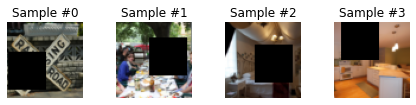

In [ ]:
# Check dataset is loading correctly 
# code from pytorch tutorial 
fig = plt.figure()

def show_img(img, mask):
  inv_norm = transforms.Normalize((-1,-1,-1), (1/0.5, 1/0.5, 1/0.5))
  img = inv_norm(img)
  plt.imshow((img*mask).permute(1,2,0))

for i in range(len(train_ds)):
    sample = train_ds[i]
    img, mask = sample

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_img(img, mask)

    if i == 3:
        plt.show()
        break

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
def find_best_ckpt():
  checkpoints = os.listdir(checkpoint_path)
  return None if len(checkpoints) == 0 else os.path.join(checkpoint_path, checkpoints[0])

In [ ]:
class GANInversionVisualizer(pl.Callback):
  def __init__(self, val_images, num_samples = 10):
    super().__init__()
    self.val_masked_imgs = val_images[:num_samples]
 
  def on_validation_epoch_end(self, trainer, pl_module):
    device = pl_module.device
    predicted_z = pl_module(self.val_masked_imgs)
    recon_x = pl_module.gen(predicted_z)

    # Log generated images
    trainer.logger.experiment.log({
        'global_step': trainer.global_step,
        'recovered': [wandb.Image(gen_img) for gen_img in recon_x]
    })

In [ ]:
# model
model = DCGANPredictorTrainer(lr, num_epochs, batch_size)

# training
cpt_callback = ModelCheckpoint(monitor="val_loss",save_top_k=1, mode="min")
wandb_logger = WandbLogger(project="dcgan-inversion-cut-1")
inv_visualize_callback = GANInversionVisualizer()

trainer = pl.Trainer(
    gpus=-1, 
    auto_lr_find=True, 
    default_root=checkpoint_path, 
    callbacks=[cpt_callback, inv_visualize_callback], 
    max_epochs=num_epochs,
    log_every_n_steps=log_every,
    logger=wandb_logger,
    )

lr_finder = trainer.tuner.lr_find(model)
print("Results: ", lr_finder.results)

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("==> Setting learning rate to: ", new_lr)

model.lr = new_lr

# Load from checkpoint (if exists) for resuming training
trainer.fit(model, train_loader, val_loader, ckpt_path=find_best_ckpt())

print("Best checkpoint path: ", cpt_callback.best_model_path)

# Load from checkpoint for inference

In [ ]:
model = DCGANPredictorTrainer.load_from_checkpoint(cpt_callback.best_model_path)